# Capstone Project - Predicting Student Final Results

#### Model Objectives:


#### About the Dataset:


In [190]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image


def plot_cat_var(column,title,size=(10,6)):
    new_d = dict(column.value_counts())
    d_keys = list(new_d.keys())
    d_values = list(new_d.values())

    plt.figure(figsize=size)
    plt.bar(d_keys, d_values,color='#1e9cbd', width=0.5)
    plt.title(title,fontsize=20)

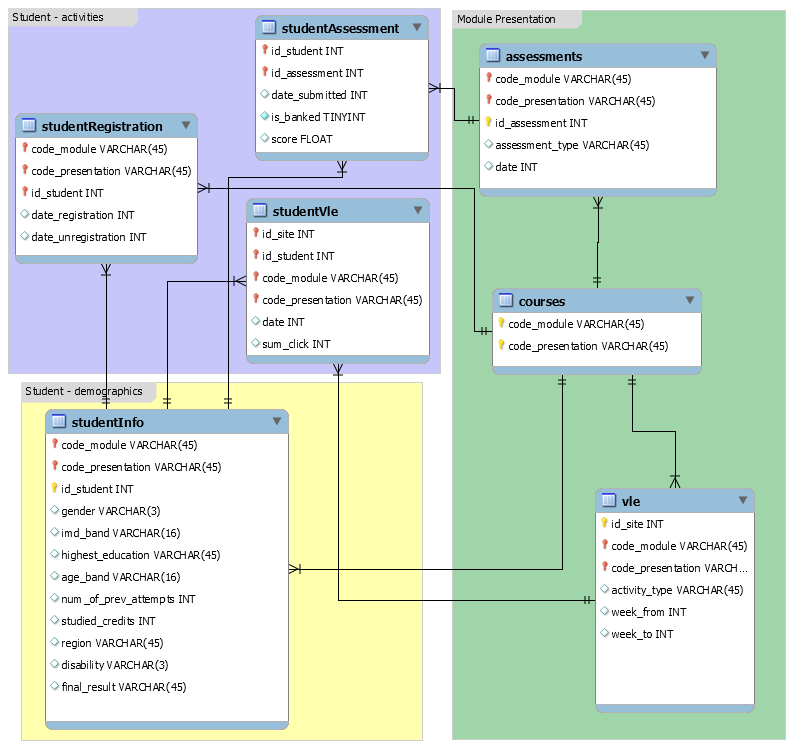

In [191]:
Image("data/model.png")

In [192]:
#loading the studentInfo table
st = pd.read_csv('data/studentInfo.csv')
st.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [193]:
st.isna().sum()

code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64

**imd_band**
* The Index of Multiple Deprivation 2015 is the official measure of relative deprivation for small areas1 (or neighbourhoods) in England.
* The Index of Multiple Deprivation ranks every small area in England from 1 (most deprived area) to 32,844 (least deprived area).
* This variable shows to which band the student belongs to.

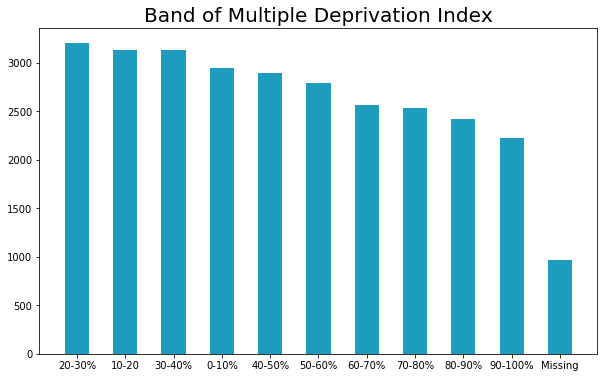

In [194]:
plot_cat_var(st_clean.imd_band,'Band of Multiple Deprivation Index')

There is not a prevailing value. I will therefore theat the missing values as its own category.


In [196]:
st.imd_band.fillna('Missing',inplace=True)

**StudentInfo Dataset description:**
* There are 32953 rows in the dataset, but only **28785 unique students**
* 52% of students are male, 48% of students are female
* 84% of students level of education is A level or below
* 70% of student are 35 or under, 29% is between 35 and 55, the remaining 1% is above the age of 55 
* 10% of students have a disability

Due to some student repeating modules, for the initial demographic analysis I will remove their duplicate information and only keep one record per student.

In [197]:
#dropping multiple records from the dataset
st_clean = pd.DataFrame.drop_duplicates (st, subset = 'id_student')

M    0.522703
F    0.477297
Name: gender, dtype: float64

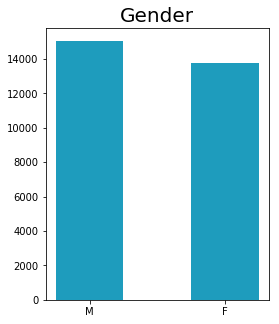

In [198]:
plot_cat_var(st_clean.gender,'Gender',size=(4,5))
st_clean.gender.value_counts(normalize=True)

A Level or Equivalent          0.429217
Lower Than A Level             0.409241
HE Qualification               0.142157
No Formal quals                0.010631
Post Graduate Qualification    0.008755
Name: highest_education, dtype: float64

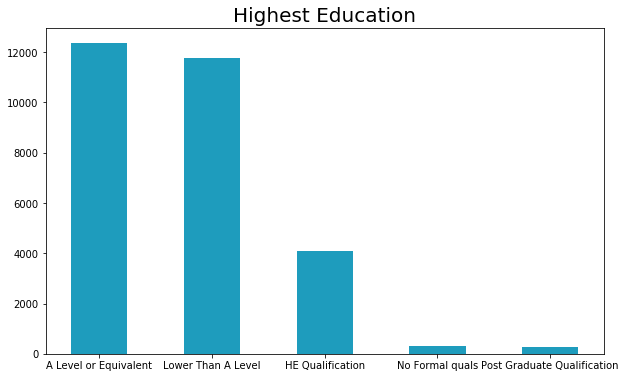

In [199]:
plot_cat_var(st_clean.highest_education,'Highest Education')
st_clean.highest_education.value_counts(normalize=True)

0-35     0.699844
35-55    0.293973
55<=     0.006184
Name: age_band, dtype: float64

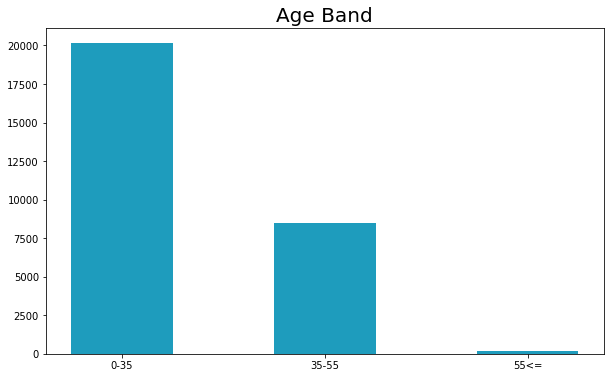

In [200]:
plot_cat_var(st_clean.age_band,'Age Band')
st_clean.age_band.value_counts(normalize=True)

N    0.905611
Y    0.094389
Name: disability, dtype: float64

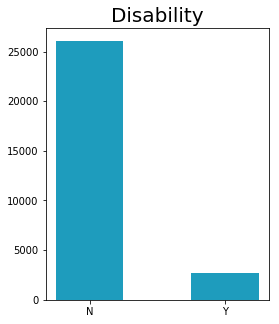

In [201]:
plot_cat_var(st_clean.disability,'Disability',size=(4,5))
st_clean.disability.value_counts(normalize=True)

**Final Results**
* 38% of students have finished their modules + 10% with a distinction
* 31% have withdrawn from a module
* 21% of students failed
* OPTION OF ANALYSIS - DOES THE AMOUNT OF INTERACTIONS EFFECT OF GETTING A DISTINCTION?

Pass           0.376342
Withdrawn      0.314157
Fail           0.217613
Distinction    0.091888
Name: final_result, dtype: float64

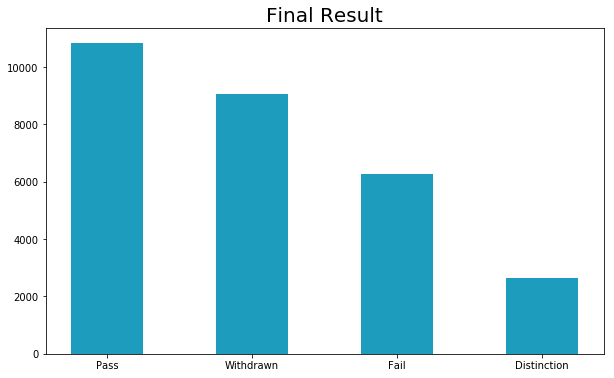

In [202]:
plot_cat_var(st_clean.final_result,'Final Result')
st_clean.final_result.value_counts(normalize=True)

In [203]:
st_clean.imd_band.value_counts()

20-30%     3200
10-20      3132
30-40%     3128
0-10%      2944
40-50%     2890
50-60%     2787
60-70%     2560
70-80%     2532
80-90%     2421
90-100%    2220
Missing     971
Name: imd_band, dtype: int64

My projected model's objective is to predict students who are likely to fail or withdraw from their module. Predicting whether a student will get a destiction is pointless for this task. For this reason, I will join students who pass with or without distinction into the same class 'Pass'.

In [204]:
#Joining 'Distinction' class with 'Pass'
st.loc[st['final_result'] == 'Distinction','final_result'] = 'Pass'

## Virtual Learning Environment Dataset (VLE)

- This table contains information about student's interactions with the virtual learning environment. 

- the materials provided in the VLE are mostly HTML pages and PDF files
- 'id_site' variable refers to the study material
- 'date' the date of the student's interaction with the material
- 'sum_click' - the number of times the student interacted with the material

In [205]:
vle = pd.read_csv('data/studentVle.csv')

In [206]:
vle.head()
#this datasetset has no missing values

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [207]:
print(len(vle.id_student.unique()))

26074


There are 26074 unique students have interacted with the VLE, but there are 26221 unique students overall. It suggests that there might be 147 students who have not used the VLE at all.

I will now find students who are not in the VLE table to investigate their results.

In [208]:
#let's find you which students are not in the VLE table
unique_vle_students = set(vle.id_student)
unique_total_students = set(st.id_student)

#this is a list of students who are not present in VLE df
students_not_in_vle = list(unique_total_students.difference(unique_vle_students))

#this is a dataframe with information about students who are not present in the VLE df
df_not_in_vle = st_clean[st_clean.id_student.isin(students_not_in_vle)]

Withdrawn    0.879749
Fail         0.119144
Pass         0.001107
Name: final_result, dtype: float64

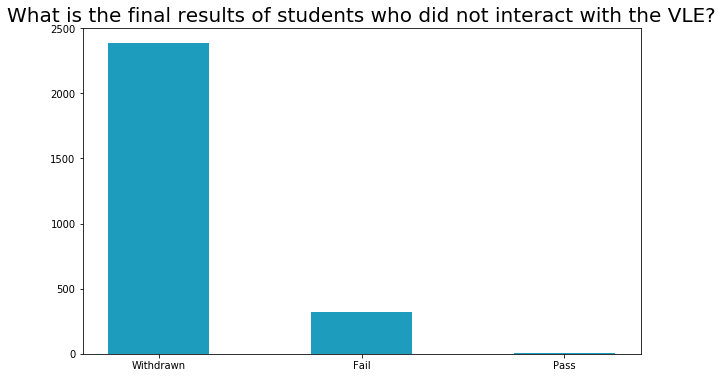

In [209]:
plot_cat_var(df_not_in_vle.final_result,'What is the final results of students who did not interact with the VLE?')
df_not_in_vle.final_result.value_counts(normalize=True)

The students who have not used the VLE at all have mostly withdrawn from the module or failed.
This suggest that these are the students who have changed their minds about the module and left without ever using the VLE. Their data will not be useful for the model.

However, there is 12% of students who failed their module in this dataset.

EXPLAIN THE MOTIVATION TO KEEP THEM IN THE DATASET


In [210]:
len(df_not_in_vle)

2711

In [211]:
#this is now a df with only students who are also in the VLE table
#st_actives = st[st['id_student'].isin(students_not_in_vle) == False]

#### Dates of student materials - too many missing values

In [212]:
activity = pd.read_csv('data/vle.csv')
activity.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [213]:
print(activity.week_from.isna().sum())
print(activity.week_to.isna().sum())
print(len(activity))

5243
5243
6364


Unfortunately, this table has too many values to determine the dates of VLE materials released

### Joining Student and VLE datasets

I will create a dataset with information about students and their interactions in VLE.

This table will be module-oriented, rather than student oriented, because there are some students who have studied multiple modules that were chosen for this project.

Moreover, the model does not aim to predict the student's overall performance, but the student's performance in a particular module.

In [214]:
#This information won't be useful - dropping columns
vle_for_joining = vle.drop(['id_site','date'],axis =1)

In [215]:
vle_for_joining.isna().sum()

code_module          0
code_presentation    0
id_student           0
sum_click            0
dtype: int64

In [216]:
vle_for_joining.head()

,code_module,code_presentation,id_student,sum_click
0,AAA,2013J,28400,4
1,AAA,2013J,28400,1
2,AAA,2013J,28400,1
3,AAA,2013J,28400,11
4,AAA,2013J,28400,1


In [217]:
#Here I will sum all clicks/interactions from the VLE table per module studied
df_sum_click = vle_for_joining.groupby(['code_module', 'code_presentation','id_student']).agg({'sum_click': ['sum']})

In [219]:
df_sum_click.head()

sum_click
                                               sum
code_module code_presentation id_student          
AAA         2013J             11391            934
                              28400           1435
                              30268            281
                              31604           2158
                              32885           1034

In [220]:
df_sum_click.columns = ['sum_of_clicks']

In [221]:
#setting a new index
df_sum_click_new_index = df_sum_click.reset_index()

In [222]:
df_sum_click_new_index.head()

,code_module,code_presentation,id_student,sum_of_clicks
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034


In [225]:
df_sum_click_new_index.isna().sum()

code_module          0
code_presentation    0
id_student           0
sum_of_clicks        0
dtype: int64

In [226]:
#merging the ST dataset with the above dataset
st_actives_with_vle = pd.merge(st, df_sum_click_new_index,
                               on=['code_module','code_presentation','id_student'],
                               how='left')

# st_new_join = st.join(df_sum_click_new_index, how='left', on=['code_module','code_presentation','id_student'])


In [227]:
st_actives_with_vle.head()
#this df now contains the total number of clicks per module and presentation!!

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


In [234]:
st_actives_with_vle.isna().sum()

code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
sum_of_clicks           0
dtype: int64

In [233]:
st_actives_with_vle.loc[st_actives_with_vle.sum_of_clicks.isna() == True]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,sum_of_clicks


In [235]:
#I will replace the NaN with 0 as they represent the students who have not interacted in the VLE
st_actives_with_vle.sum_of_clicks.fillna(0,inplace=True)

#### Outliers in sum_of_clicks

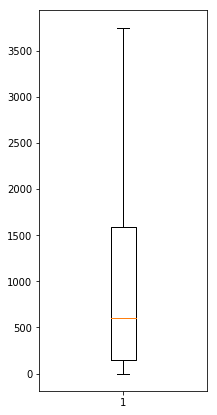

In [236]:
plt.figure(figsize=(3,7))
plt.boxplot(st_actives_with_vle.sum_of_clicks,showfliers=False);

In [237]:
st_actives_with_vle.sum_of_clicks.describe()

count    32593.000000
mean      1215.141257
std       1692.604449
min          0.000000
25%        142.000000
50%        602.000000
75%       1585.000000
max      24139.000000
Name: sum_of_clicks, dtype: float64

Distribution of clicks:
* Median - 717 clicks
* Mean - 1326
* this is a heavily skewed distribution due to the large number of outliers
* normalisation might help with outliers

### Assessments table

In [262]:
df_a = pd.read_csv('data/studentAssessment.csv')

In [263]:
df_a.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [279]:
df_as = pd.read_csv('data/assessments.csv')

This file contains information about assessments in module-presentations. Usually, every presentation has a number of assessments followed by the final exam.

date – information about the final submission date of the assessment calculated as the number of days since the start of the module-presentation. The starting date of the presentation has number 0 (zero).

As will remove all assessments that happen after 100 days, to train the dataset on early assignments only.

In [280]:
df_as.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


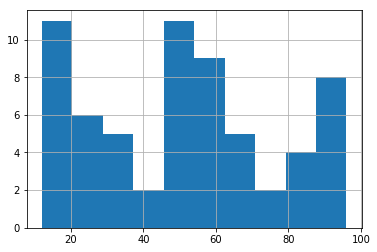

In [284]:
df_as.date.hist()

In [282]:
df_as = df_as[df_as.date < 100]

In [283]:
df_as.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
6,AAA,2014J,1758,TMA,19.0,10.0
7,AAA,2014J,1759,TMA,54.0,20.0
12,BBB,2013B,14991,CMA,54.0,1.0


### Preparing Variables for Modelling

In [238]:
#renaming df
df = st_actives_with_vle.copy()
df.rename(columns={"final_result": "target"}, inplace=True)

#### Dropping unneccesary columns

In [239]:
to_drop = ['id_student']
df.drop(to_drop, axis=1,inplace=True)

In [240]:
df.head()

,code_module,code_presentation,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,target,sum_of_clicks
0,AAA,2013J,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,934.0
1,AAA,2013J,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,1435.0
2,AAA,2013J,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,281.0
3,AAA,2013J,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2158.0
4,AAA,2013J,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,1034.0


#### Creating dummy variables

In [243]:
#selecting categorical columns
cat_cols = ['code_module', 'code_presentation', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band','disability']

df = pd.get_dummies(data=df,columns = cat_cols)

In [244]:
df.head()

,num_of_prev_attempts,studied_credits,target,sum_of_clicks,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,...,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_Missing,age_band_0-35,age_band_35-55,age_band_55<=,disability_N,disability_Y
0,0,240,Pass,934.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
1,0,60,Pass,1435.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,60,Withdrawn,281.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,60,Pass,2158.0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,60,Pass,1034.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [48]:
df.columns

Index(['num_of_prev_attempts', 'studied_credits', 'target', 'sum_of_clicks',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',

In [245]:
df.rename(columns={'age_band_55<=': "55+"}, inplace=True)

#### Splitting dataset - training, validation, testing set

In [246]:
from sklearn.model_selection import train_test_split

#I am going to cut away a random 5% of the dataset for final testing.

X_testing_set = df.drop('target',axis=1)
y_testing_set = df.target

#ts = 'TESTING SET'
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(X_testing_set, y_testing_set, test_size=0.05, random_state=123)

In [247]:
#putting my df back together
df = pd.concat([X_train_ts, y_train_ts],axis=1)

The following variables now contain the 5% testing set

df validation set:
   * y_test_ts - labels
   * X_test_ts - data

Creating the validation set (10% of data)

In [248]:
X = df.drop('target',axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

### Tackling class imbalace

Pass         0.472532
Withdrawn    0.312050
Fail         0.215418
Name: target, dtype: float64

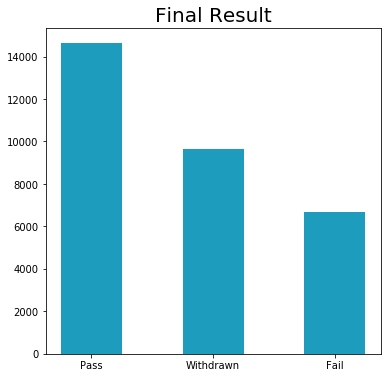

In [249]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

In [250]:
#to avoid data leakage when using SMOTE, I have split the data beforehand

from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train)

C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classe

In [251]:
#putting upsampled dataset back together
X_train = pd.DataFrame(X_train, columns=X_train_ts.columns)
y_train = pd.Series(y_train)

df = pd.concat([X_train,y_train],axis=1)

In [252]:
df.rename(columns={0: "target"}, inplace=True)

In [253]:
df.shape

(39393, 51)

In [254]:
df.head()

,num_of_prev_attempts,studied_credits,sum_of_clicks,code_module_AAA,code_module_BBB,code_module_CCC,code_module_DDD,code_module_EEE,code_module_FFF,code_module_GGG,...,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,imd_band_Missing,age_band_0-35,age_band_35-55,55+,disability_N,disability_Y,target
0,0.0,60.0,198.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Withdrawn
1,0.0,60.0,351.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Fail
2,1.0,60.0,3093.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Pass
3,0.0,355.0,1173.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,Withdrawn
4,1.0,60.0,101.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Fail


Fail         0.333333
Withdrawn    0.333333
Pass         0.333333
Name: target, dtype: float64

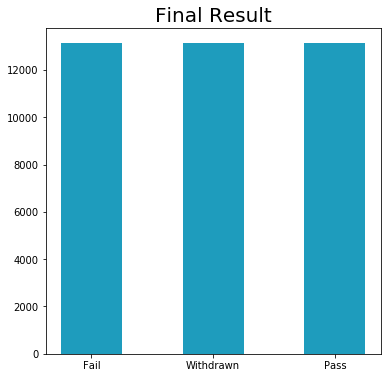

In [255]:
plot_cat_var(df.target,'Final Result',size=(6,6))
df.target.value_counts(normalize=True)

In [61]:
X_train.columns

Index(['num_of_prev_attempts', 'studied_credits', 'sum_of_clicks',
       'code_module_AAA', 'code_module_BBB', 'code_module_CCC',
       'code_module_DDD', 'code_module_EEE', 'code_module_FFF',
       'code_module_GGG', 'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'highest_education_A Level or Equivalent',
       'highest_education_HE Qualification',
       'highest_education_Lower Than A Level',
       'highest_education_No Formal quals',
       'highest_education_Post Graduate Qualification', 'imd_band_0-10%',
       'i

## Modelling

In [256]:
#importing libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

#import stats_for_classification as stats
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pylab as pl
import xgboost

In [257]:
#PCA compression
#scaling data for PCA
scaler = StandardScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train))

In [258]:
pca_1 = PCA(n_components=45)

principalComponents = pca_1.fit_transform(scaled_X_train)

In [259]:
#looking at explained variance ratio of different number of components
print(np.sum(pca_1.explained_variance_ratio_))

0.9999999999999999


In [260]:
#baseline model without gridsearch
pipe_baseline = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=45)),
                  ('clf', RandomForestClassifier(random_state = 123))])

pipe_baseline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scl', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=45,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                       

In [261]:
print('Training score: :'+str(pipe_baseline.score(X_train,y_train)))
print('Testing score: :'+str(pipe_baseline.score(X_test,y_test)))

Training score: :0.9994922955855101
Testing score: :0.6528898934452696


In [70]:
#let's try this model with gridsearch
pipe_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                  ('pca', PCA(n_components=45)),
                  ('clf', RandomForestClassifier(random_state = 123,n_jobs=6))])

# Set grid search params
param_baseline_grid = [ 
  {'clf__n_estimators': [40,50,70],
   'clf__criterion': ['gini','entropy'], 
   'clf__max_depth': [10,15,20],  
   'clf__min_samples_leaf':[0.02,0.002],  
  }]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_baseline_grid,
            param_grid=param_baseline_grid,
            scoring='accuracy',
            cv=3, verbose=True, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  2.5min finished


Best accuracy: 0.510

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 0.002, 'clf__n_estimators': 40}


In [71]:
print('Training score: :'+str(gs_rf.score(X_train,y_train)))
print('Testing score: :'+str(gs_rf.score(X_test,y_test)))

Training score: :0.6149482155815027
Testing score: :0.5330012453300125


In [ ]:
#Best accuracy: 0.435
#Best params:
 #{'clf__criterion': 'gini', 'clf__max_depth': 20, 'clf__min_samples_leaf': 0.002, 'clf__n_estimators': 70}
    
    



In [72]:
predictions_grid_rf = gs_rf.predict(X_test)

confusion_matrix(y_test,predictions_grid_rf)

array([[ 79, 435, 130],
       [ 45, 978, 106],
       [ 34, 375, 227]], dtype=int64)

In [ ]:
#Instantiate XGBClassifier
#xgb_cl_pipeline = XGBClassifier(nthread=5)


#xgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
             #    ('pca', PCA(n_components=40)),
             #    ('clf', xgb_cl_pipeline)])

# Set grid search params
#param_grid_xgb = {
 #   'learning_rate': [0.1,0.2,0.3], #=eta, smaller number makes model more robust by shrinking weights on each step
 #   'max_depth': [20,30,40,50], #max depth of a three, controls over-fitting
 #   'min_child_weight': [40,60,80], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
 #  'subsample': [0.2,0.5], #the fraction of observations to be randomly samples for each tree.
 #   'n_estimators': [30,50,60,70],
#}


#grid_xgb = GridSearchCV(xgb_cl_pipeline, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
#grid_xgb.fit(X_train, y_train)

#best_parameters = grid_xgb.best_params_

#print('Grid Search found the following optimal parameters: ')
#for param_name in sorted(best_parameters.keys()):
#    print('%s: %r' % (param_name, best_parameters[param_name]))

#training_preds = grid_xgb.predict(X_train)
#test_preds = grid_xgb.predict(X_test)
#training_accuracy = accuracy_score(y_train, training_preds)
#test_accuracy = accuracy_score(y_test, test_preds)

#print('')
#print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
#print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 30
#min_child_weight: 60
#n_estimators: 50
#subsample: 0.5

#Training Accuracy: 63.73%
#Validation accuracy: 60.96%



#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 20
#min_child_weight: 80
#n_estimators: 50
#subsample: 0.5

#Training Accuracy: 69.57%
#Validation accuracy: 66.33%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 40
#n_estimators: 70
#subsample: 0.5

#Training Accuracy: 70.81%
#Validation accuracy: 66.71%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 35
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 71.89%
#Validation accuracy: 66.83%

In [74]:
X_train = X_train.astype(int)
X_test = X_test.astype(int)

In [78]:
#Instantiate XGBClassifier
xgb_cl_pipeline = XGBClassifier(nthread=6)


xgb_baseline_grid = Pipeline([('scl', MinMaxScaler()),
                 ('pca', PCA(n_components=40)),
                 ('clf', xgb_cl_pipeline)])

# Set grid search params
param_grid_xgb = {
    'learning_rate': [0.1], #=eta, smaller number makes model more robust by shrinking weights on each step
    'max_depth': [40], #max depth of a three, controls over-fitting
    'min_child_weight': [15], #minimum sum of weights of all observations required in a child, higher values reduce over-fitting
   'subsample': [0.5], #the fraction of observations to be randomly samples for each tree.
    'n_estimators': [100,130],
}


grid_xgb = GridSearchCV(xgb_cl_pipeline, param_grid_xgb, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train, y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(X_train)
test_preds = grid_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 40
min_child_weight: 15
n_estimators: 130
subsample: 0.5

Training Accuracy: 84.57%
Validation accuracy: 65.01%


In [ ]:
#result resampled with three classes

#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 30
#min_child_weight: 35
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 74.36%
#Validation accuracy: 65.84%



#Grid Search found the following optimal parameters: 
#learning_rate: 0.2
#max_depth: 40
#min_child_weight: 20
#n_estimators: 80
#subsample: 0.5

#Training Accuracy: 82.46%
#Validation accuracy: 64.8%


#Grid Search found the following optimal parameters: 
#learning_rate: 0.1
#max_depth: 40
#min_child_weight: 15
#n_estimators: 100
#subsample: 0.5

#Training Accuracy: 82.41%
#Validation accuracy: 65.3%

In [ ]:
#creating a df with the total number of clicks in VLE per student
df_sum_click = vle.groupby('id_student').sum()
df_sum_click.drop(['id_site','date'], axis=1, inplace=True)

In [ ]:
df_sum_click.head()

In [ ]:
#I will now join this table with the main table of students

In [ ]:
st_with_total_clicks = st_clean.set_index('id_student')

In [ ]:
st_with_total_clicks = st_with_total_clicks.join(df_sum_click)

In [ ]:
st_with_total_clicks.isna().sum()

In [ ]:
st_with_total_clicks.sum_click = st_with_total_clicks.sum_click.dropna()

In [ ]:
len(st_with_total_clicks)

In [ ]:
#now we have a dataframe with all students including their total number of VLE interactions
st_with_total_clicks.sum_click.describe()

**How much do students interact with the VLE?**
* mean number of clicks (across all modules): 1375
* median number of clicks (across all modules): 686
* the large difference between the mean and the median is caused by heavily skewed data
* student with the highest number of clicks: 28615

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(st_with_total_clicks.sum_click, bins=100);

In [ ]:
#try plotting average grade with num_clicks

In [ ]:
assessment = pd.read_csv('data/studentAssessment.csv')

In [ ]:
assessment.head()

In [ ]:
assessment.dropna(inplace=True)

In [ ]:
assessment.isna().sum()

In [ ]:
len(assessment)

In [ ]:
assessment = assessment.groupby('id_student').median()

In [ ]:
assessment.drop(['id_assessment','date_submitted','is_banked'],axis=1, inplace=True)

In [ ]:
assessment.head()

In [ ]:
st_with_total_clicks = st_with_total_clicks.join(assessment)

In [ ]:
st_with_total_clicks.head()

In [ ]:
st_with_total_clicks.isna().sum()

In [ ]:
len(st_with_total_clicks)

In [ ]:
#INVESTIGATE WHY THE DIFFERENCE - WHY IS THERE SMALLER NUMBER OF STUDENTS IN ASSESSMENT THAN IN 
#TOTAL TABLE

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(st_with_total_clicks.sum_click, st_with_total_clicks.score, alpha = 0.1)

In [ ]:
# Get names of indexes for which column Age has value 30
indexNames = st_with_total_clicks[st_with_total_clicks['sum_click'] > 2000].index
 
# Delete these row indexes from dataFrame
st_with_total_clicks_no_high_clicks = st_with_total_clicks.drop(indexNames)

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(st_with_total_clicks_no_high_clicks.sum_click, st_with_total_clicks_no_high_clicks.score, alpha = 0.1)

In [ ]:
#preparing dataset for baseline model
#classification model, goal: labels modules where particular student is likely to fail,
#withdraw, pass, or pass with distinction
#module oriented dataset- row = module with info about student


In [ ]:
original_assessment = pd.read_csv('data/studentAssessment.csv')

In [ ]:
assessment.head()

In [ ]:
original_assessment.head()

In [ ]:
assess_info = pd.read_csv('data/assessments.csv')

In [ ]:
assess_info.head()

In [ ]:
len(assess_info.code_module.unique())
#206 unique assessments

In [ ]:
st.head()

In [ ]:
len(st)

In [ ]:
len(st.id_student.unique())

In [ ]:
courses = pd.read_csv('data/courses.csv')

In [ ]:
courses

In [ ]:
st.head()


In [ ]:
st.code_module.unique()

In [ ]:
st['code_module'] = st['code_module'].replace({'AAA':'A','BBB':'B','CCC':'C','DDD':'D','EEE':'E','FFF':'F', 'GGG':'G'})

In [ ]:
st['code_presentation'] = st['code_presentation'].replace({'2013J':'2013OCT','2013B':'2013FEB','2014J':'2014OCT','2014B':'2014FEB'})

In [ ]:
st["module"] = st["code_module"] +'_'+ st["code_presentation"]

In [ ]:
st.head()

In [ ]:
st = st.drop(['code_module', 'code_presentation'],axis = 1)

In [ ]:
reg = pd.read_csv('data/studentRegistration.csv')

In [ ]:
len(reg)